## TEXT MINING PROJECT - Davide Croatto, Hubert Nowak, Eleonora Zullo

## Import libraries and data

### Import libraries

In [ ]:
# to import data
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# for text classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# to use BERT
from transformers import BertTokenizer, BertModel, BertConfig,BertForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from transformers.utils import PushToHubMixin
from transformers import Trainer, TrainingArguments

In [ ]:
from collections import defaultdict
from pathlib import Path
import math

In [ ]:
from peft.tuners.lora.layer import dispatch_default, Linear
from peft.tuners.tuners_utils import BaseTunerLayer
from peft import LoraConfig, PeftModel, LoraModel, get_peft_model, AdaLoraConfig

In [ ]:
from datasets import load_dataset
import evaluate

In [ ]:
!pip install peft datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [ ]:
# for topic modeling
import os
import gensim as gensim
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Import data

Dataset originale

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/test.csv")

Later on the code you can find how we obtained the following processed data.

In [ ]:
preprocessed_train = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/preprocessed_train.csv")
preprocessed_test = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/preprocessed_test.csv")

## Data exploration and preprocessing

### Exploration

In [ ]:
train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


1 = World, 2 = Sport, 3 = Business, 4 = Sci/Tech

In [ ]:
train.isnull().sum()

,0
Class Index,0
Title,0
Description,0


In [ ]:
test.isnull().sum()

,0
Class Index,0
Title,0
Description,0


In [ ]:
# substitute the number with the specific category
class_mapping = {1: 'World', 2: 'Sport', 3: 'Business', 4: 'Sci/Tech'}
train['Class Index'] = train['Class Index'].replace(class_mapping)
test['Class Index'] = test['Class Index'].replace(class_mapping)

In [ ]:
# create a column in which is contained the title and the description
train['text'] = train['Title'] + ' ' + train['Description']
test['text'] = test['Title'] + ' ' + test['Description']

In [ ]:
# drop the title and the description columns
train = train.drop('Title', axis=1)
train = train.drop('Description', axis=1)

test = test.drop('Title', axis=1)
test = test.drop('Description', axis=1)

In [ ]:
new_train = train.sample(n=30000, random_state=42)
# we select only 30000 records from the train set
# this to reduce the computational time
# we choose 30000 records as the test set has a dimension of 7000 records
# so that train set = 70%, test set = 30%

In [ ]:
new_train.shape

(30000, 2)

In [ ]:
# to verify the balance in the different classes
new_train['Class Index'].value_counts()

,count
Class Index,
Sport,7560
Sci/Tech,7528
World,7472
Business,7440


### Text preprocessing

Data_processing function.

In [ ]:
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

# Custom words to add to the stopwords
custom_stopwords = {"ap", "reuters", "gt", "lt", "href", "said", "afp", "quickinfo", "corp", "inc", "com", "co"}

def data_processing(text):
    text = re.sub(r'http\S+|www\S+', '', text)                             # removing URL
    text = re.sub(r"[^a-zA-Z]", " ", text)                                 # removing non-alphabetic characters
    text = re.sub(r" {2,}", " ", text)                                     # reducing multiple spaces
    text = text.lower()                                                    # converting to lowercase
    stopword = set(stopwords.words('english')) | custom_stopwords          # defining stopwords
    spacy_doc = nlp(text)                                                  # for lemmatization
    return_arr = [token.lemma_ for token in spacy_doc
                  if token.text not in stopword and not token.is_punct]    # removing stopwords and lemmatization
    return return_arr

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# apply the function to the train (new_train) set and to the test set
new_train['processed'] = new_train['text'].apply(data_processing)
test['processed'] = test['text'].apply(data_processing)

Trigrams

In [ ]:
# to find the most frequent trigrams
texts =  preprocessed_train['processed'].apply(lambda x: ''.join(x))

vectorizer = CountVectorizer(ngram_range=(3, 3)) # Define trigrams

X = vectorizer.fit_transform(texts)

trigram_freq = X.sum(axis=0).A1 # Get frequency of trigrams
trigram_names = vectorizer.get_feature_names_out() # Get names of trigrams

trigram_counts = dict(zip(trigram_names, trigram_freq)) # Create a dictionary

# Sort the dictionary by frequency in descending order and print the top N trigrams
N = 20 # Specify how many of the most common trigrams to print
for trigram, frequency in Counter(trigram_counts).most_common(N):
  print(f"{trigram}: {frequency}")

quote profile research: 233
arial helvetica size: 109
face verdana ms: 109
font face verdana: 109
helvetica size color: 109
ms sans serif: 109
sans serif arial: 109
serif arial helvetica: 109
verdana ms sans: 109
third quarter profit: 88
high oil price: 84
president george bush: 73
third quarter earning: 73
color washington post: 64
info qcat news: 64
infotype info qcat: 64
qtype sym infotype: 64
size color washington: 64
sym infotype info: 64
washington post font: 64


In [ ]:
# list of most frequent trigrams
trigrams = [
    ('new', 'york', 'yankees'),
    ('green', 'bay', 'packer'),
    ('national', 'basketball', 'association'),
    ('boston', 'red', 'sox'),
    ('major', 'league', 'baseball'),
    ('st', 'louis', 'cardinal'),
    ('los', 'angeles', 'dodger'),
    ('cbc', 'sport', 'online'),
    ('new', 'england', 'patriot'),
    ('new', 'york', 'giants'),
    ('san', 'francisco', 'giant'),
    ('national', 'hockey', 'league'),
    ('new', 'jersey', 'net'),
    ('three', 'run', 'homer'),
    ('san', 'francisco', 'giants'),
    ('red', 'bull', 'racing'),
    ('san', 'antonio', 'spur'),
    ('madison', 'square', 'garden'),
    ('dale', 'earnhardt', 'jr'),
    ('deutsche', 'bank', 'championship'),
    ('english', 'premier', 'league'),
    ('tampa', 'bay', 'buccaneer'),
    ('justine', 'henin', 'hardenne'),
    ('portland', 'trail', 'blazer'),
    ('paris', 'st', 'germain'),
    ('security', 'exchange', 'commission'),
    ('chief', 'executive', 'officer'),
    ('world', 'trade', 'organization'),
    ('initial', 'public', 'offering'),
    ('delta', 'air', 'lines'),
    ('international', 'monetary', 'fund'),
    ('european', 'central', 'bank'),
    ('johnson', 'amp', 'johnson'),
    ('gross', 'domestic', 'product'),
    ('blue', 'chip', 'stock'),
    ('grand', 'theft', 'auto'),
    ('blu', 'ray', 'disc'),
    ('mount', 'st', 'helens'),
    ('european', 'space', 'agency'),
    ('osama', 'bin', 'laden'),
    ('musab', 'al', 'zarqawi'),
    ('prime', 'minister', 'john'),
    ('muqtada', 'al', 'sadr'),
    ('new', 'york', 'stock'),
    ('port', 'au', 'prince'),
    ('new', 'york', 'times'),
    ('pope', 'john', 'paul'),
    ('san', 'suu', 'kyi')
]

In [ ]:
# function to join specified trigrams with underscores
def join_trigrams(text, trigrams):
    trigrams_set = set(trigrams)
    result = []
    skip_next_two = False  # Adjusted for trigrams

    for i in range(len(text) - 2):  # Adjusted loop range for trigrams
        if skip_next_two:
            skip_next_two = False
            continue

        if (text[i], text[i + 1], text[i + 2]) in trigrams_set:
            result.append(f"{text[i]}_{text[i + 1]}_{text[i + 2]}")
            skip_next_two = True
        else:
            result.append(text[i])

    # Add the last two words if not part of a trigram
    if not skip_next_two:
        result.extend(text[-2:])  # Adjusted to add two words

    return result

new_train['processed'] = new_train['processed'].apply(lambda x: ' '.join(join_trigrams(x, trigrams)).split())
test['processed'] = test['processed'].apply(lambda x: ' '.join(join_trigrams(x, trigrams)).split())

new_train.head()

,Class Index,text,processed
71787,Business,"BBC set for major shake-up, claims newspaper L...","[bbc, set, major, shake, claim, newspaper, lon..."
67218,Business,Marsh averts cash crunch Embattled insurance b...,"[marsh, avert, cash, crunch, embattle, insuran..."
54066,Sport,"Jeter, Yankees Look to Take Control (AP) AP - ...","[jeter, yankee, look, take, control, derek, je..."
7168,Sci/Tech,Flying the Sun to Safety When the Genesis caps...,"[fly, sun, safety, genesis, capsule, come, bac..."
29618,Business,Stocks Seen Flat as Nortel and Oil Weigh NEW ...,"[stock, see, flat, nortel, oil, weigh, new, yo..."


Bigrams

In [ ]:
# to find the most frequent bigrams
texts =  new_train[new_train['Class Index'] == 'World']['processed'].apply(lambda x: ')('.join(x))

vectorizer = CountVectorizer(ngram_range=(2, 2)) # Define bigrams
X = vectorizer.fit_transform(texts)

bigram_freq = X.sum(axis=0).A1 # Get frequency of bigrams
bigram_names = vectorizer.get_feature_names_out() # Get names of bigrams

bigram_counts = dict(zip(bigram_names, bigram_freq)) # Create a dictionary

# Sort the dictionary by frequency in descending order and print the top N bigrams
N = 20  # Specify how many of the most common bigrams to print
for bigram, frequency in Counter(bigram_counts).most_common(N):
    print(f"{bigram}: {frequency}")

prime minister: 531
president bush: 265
canadian press: 231
united states: 212
united nations: 192
yasser arafat: 190
kill least: 177
presidential election: 158
john kerry: 156
new york: 154
car bomb: 144
north korea: 142
gaza strip: 136
least people: 135
west bank: 124
press canadian: 115
ariel sharon: 114
tony blair: 113
al qaeda: 110
year old: 110


In [ ]:
# # list of most frequent bigrams
bigrams = [
    ('hurricane','ivan'),
    ('kill','least'),
    ('car','bomb'),
    ('security','force'),
    ('george','bush'),
    ('human','right'),
    ('new', 'york'),
    ('red', 'sox'),
    ('last', 'night'),
    ('sport', 'network'),
    ('world', 'cup'),
    ('gold', 'medal'),
    ('united', 'states'),
    ('los', 'angeles'),
    ('st', 'louis'),
    ('year', 'old'),
    ('ryder', 'cup'),
    ('world', 'series'),
    ('score', 'point'),
    ('manchester', 'united'),
    ('major', 'league'),
    ('san', 'francisco'),
    ('grand', 'prix'),
    ('formula', 'one'),
    ('monday', 'night'),
    ('tuesday', 'night'),
    ('national', 'league'),
    ('notre', 'dame'),
    ('champions', 'league'),
    ('home', 'run'),
    ('american', 'league'),
    ('second', 'round'),
    ('tiger', 'wood'),
    ('real', 'madrid'),
    ('premier', 'league'),
    ('semi', 'final'),
    ('head', 'coach'),
    ('houston', 'astros'),
    ('vijay', 'singh'),
    ('champion', 'trophy'),
    ('kansas', 'city'),
    ('wild', 'card'),
    ('last', 'year'),
    ('us', 'open'),
    ('roger', 'federer'),
    ('andy', 'roddick'),
    ('miami', 'dolphin'),
    ('regular', 'season'),
    ('tampa', 'bay'),
    ('montreal', 'expos'),
    ('paul', 'hamm'),
    ('andre', 'agassi'),
    ('green', 'bay'),
    ('indiana', 'pacer'),
    ('southern', 'california'),
    ('david', 'beckham'),
    ('maria', 'sharapova'),
    ('serena', 'williams'),
    ('north', 'carolina'),
    ('fenway', 'park'),
    ('new', 'england'),
    ('new', 'zealand'),
    ('san', 'diego'),
    ('south', 'africa'),
    ('league', 'baseball'),
    ('field', 'goal'),
    ('china', 'open'),
    ('detroit', 'piston'),
    ('hockey', 'league'),
    ('olympic', 'game'),
    ('uefa', 'cup'),
    ('arsene', 'wenger'),
    ('right', 'hander'),
    ('las', 'vegas'),
    ('michael', 'schumacher'),
    ('minnesota', 'twin'),
    ('toronto', 'blue'),
    ('prime', 'minister'),
    ('president', 'bush'),
    ('united', 'nations'),
    ('yasser', 'arafat'),
    ('john', 'kerry'),
    ('north', 'korea'),
    ('gaza', 'strip'),
    ('west', 'bank'),
    ('ariel', 'sharon'),
    ('tony', 'blair'),
    ('al', 'qaeda'),
    ('ivory', 'coast'),
    ('foreign', 'minister'),
    ('european', 'union'),
    ('security', 'council'),
    ('darfur', 'region'),
    ('middle', 'east'),
    ('hamid', 'karzai'),
    ('colin', 'powell'),
    ('new', 'delhi'),
    ('nuclear', 'program'),
    ('african', 'union'),
    ('india', 'pakistan'),
    ('kofi', 'annan'),
    ('saddam', 'hussein'),
    ('white', 'house'),
    ('south', 'korea'),
    ('supreme', 'court'),
    ('secretary', 'general'),
    ('vladimir', 'putin'),
    ('bin', 'laden'),
    ('osama', 'bin'),
    ('new', 'jersey'),
    ('new', 'orleans'),
    ('abu', 'ghraib'),
    ('north', 'korean'),
    ('abu', 'musab'),
    ('manmohan', 'singh'),
    ('vice', 'president'),
    ('south', 'african'),
    ('stock', 'fullquote'),
    ('wall', 'street'),
    ('chief', 'executive'),
    ('open', 'source'),
    ('year', 'ago'),
    ('mobile', 'phone'),
    ('search', 'engine'),
    ('presidential', 'election'),
    ('web', 'site'),
    ('wal', 'mart'),
    ('crude', 'oil'),
    ('video', 'game'),
    ('federal', 'reserve'),
    ('first', 'time'),
    ('next', 'year'),
    ('canadian', 'press'),
    ('interest', 'rate'),
    ('operating', 'system'),
    ('george', 'bush'),
    ('al', 'qaida'),
    ('hewlett', 'packard'),
    ('time', 'warner'),
    ('nuclear', 'weapon'),
    ('pervez', 'musharraf'),
    ('walt', 'disney'),
    ('al', 'sadr'),
    ('climate', 'change'),
    ('delta', 'air'),
    ('high', 'court'),
    ('last', 'season'),
    ('central', 'bank'),
    ('blu', 'ray'),
    ('long', 'term'),
    ('sun', 'microsystem'),
    ('davis', 'cup'),
    ('security', 'exchange_commission'),
    ('top', 'seed'),
    ('federal', 'judge'),
    ('heart', 'attack'),
    ('health', 'care'),
    ('number', 'one'),
    ('coca', 'cola'),
    ('free', 'agent'),
    ('general', 'manager'),
    ('us', 'military'),
]


In [ ]:
# function to join specified bigrams with underscores
def join_bigrams(text, bigrams):
    bigrams_set = set(bigrams)
    result = []
    skip_next = False

    for i in range(len(text) - 1):
        if skip_next:
            skip_next = False
            continue

        if (text[i], text[i + 1]) in bigrams_set:
            result.append(f"{text[i]}_{text[i + 1]}")
            skip_next = True
        else:
            result.append(text[i])

    if not skip_next:
        result.append(text[-1])

    return result

new_train['processed'] = new_train['processed'].apply(lambda x: ' '.join(join_bigrams(x, bigrams)).split())
test['processed'] = test['processed'].apply(lambda x: ' '.join(join_bigrams(x, bigrams)).split())

new_train.head()

,Class Index,text,processed
71787,Business,"BBC set for major shake-up, claims newspaper L...","[bbc, set, major, shake, claim, newspaper, lon..."
67218,Business,Marsh averts cash crunch Embattled insurance b...,"[marsh, avert, cash, crunch, embattle, insuran..."
54066,Sport,"Jeter, Yankees Look to Take Control (AP) AP - ...","[jeter, yankee, look, take, control, derek, je..."
7168,Sci/Tech,Flying the Sun to Safety When the Genesis caps...,"[fly, sun, safety, genesis, capsule, come, bac..."
29618,Business,Stocks Seen Flat as Nortel and Oil Weigh NEW ...,"[stock, see, flat, nortel, oil, weigh, new_yor..."


In [ ]:
# now that we have the processed column, we drop the initial text column
new_train = new_train.drop('text', axis=1)
test = test.drop('text', axis=1)

In [ ]:
# we save the results in csv files
new_train.to_csv('/content/gdrive/My Drive/Text_mining_project/preprocessed_train.csv', index=False)
test.to_csv('/content/gdrive/My Drive/Text_mining_project/preprocessed_test.csv', index=False)

In [ ]:
# we import the just saved data (we will use it later)
preprocessed_train = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/preprocessed_train.csv")
preprocessed_train.head()

,Class Index,processed
0,Business,"['bbc', 'set', 'major', 'shake', 'claim', 'new..."
1,Business,"['marsh', 'avert', 'cash', 'crunch', 'embattle..."
2,Sport,"['jeter', 'yankee', 'look', 'take', 'control',..."
3,Sci/Tech,"['fly', 'sun', 'safety', 'genesis', 'capsule',..."
4,Business,"['stock', 'see', 'flat', 'nortel', 'oil', 'wei..."


In [ ]:
preprocessed_test = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/preprocessed_test.csv")
preprocessed_test.head()

,Class Index,text,processed
0,Business,Fears for T N pension after talks Unions repre...,"['fear', 'n', 'pension', 'talk', 'union', 'rep..."
1,Sci/Tech,The Race is On: Second Private Team Sets Launc...,"['race', 'second', 'private', 'team', 'set', '..."
2,Sci/Tech,Ky. Company Wins Grant to Study Peptides (AP) ...,"['ky', 'company', 'win', 'grant', 'study', 'pe..."
3,Sci/Tech,Prediction Unit Helps Forecast Wildfires (AP) ...,"['prediction', 'unit', 'helps', 'forecast', 'w..."
4,Sci/Tech,Calif. Aims to Limit Farm-Related Smog (AP) AP...,"['calif', 'aim', 'limit', 'farm', 'relate', 's..."


## Text classification

Define train and test sets.

In [ ]:
x_train = preprocessed_train['processed']
y_train = preprocessed_train['Class Index']
x_test = preprocessed_test['processed']
y_test = preprocessed_test['Class Index']




### Using Bag of Words for text representation

Define the BoW.

In [ ]:
vectorizer = CountVectorizer(
    preprocessor=None,    # no preprocessing
    tokenizer=None,       # no tokenization
    stop_words=None       # no removing other stopwords
)

x_train_transformed = vectorizer.fit_transform(x_train)
x_test_transformed = vectorizer.transform(x_test)

#### Decision tree classifier

In [ ]:
clf = DecisionTreeClassifier().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.7676315789473684

Classification Report:
               precision    recall  f1-score   support

    Business       0.72      0.71      0.71      1900
    Sci/Tech       0.72      0.74      0.73      1900
       Sport       0.84      0.87      0.86      1900
       World       0.80      0.76      0.77      1900

    accuracy                           0.77      7600
   macro avg       0.77      0.77      0.77      7600
weighted avg       0.77      0.77      0.77      7600



#### Sparse vector classifier

In [ ]:
clf = SVC().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.8968421052631579

Classification Report:
               precision    recall  f1-score   support

    Business       0.86      0.85      0.86      1900
    Sci/Tech       0.87      0.88      0.87      1900
       Sport       0.93      0.98      0.95      1900
       World       0.92      0.88      0.90      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



#### Random forest classifier

In [ ]:
clf = RandomForestClassifier().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.8627631578947368

Classification Report:
               precision    recall  f1-score   support

    Business       0.82      0.82      0.82      1900
    Sci/Tech       0.84      0.83      0.83      1900
       Sport       0.89      0.96      0.92      1900
       World       0.90      0.84      0.87      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



### Using TF-IDF  for text representation

Define the TF-IDF matrix.

In [ ]:
vectorizer2 = TfidfVectorizer(
    preprocessor=None,    # no preprocessing
    tokenizer=None,       # no tokenization
    stop_words=None       # no removing other stopwords
)

x_train_transformed = vectorizer2.fit_transform(x_train)
x_test_transformed = vectorizer2.transform(x_test)

#### Decison tree classifier

In [ ]:
clf = DecisionTreeClassifier().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.7582894736842105

Classification Report:
               precision    recall  f1-score   support

    Business       0.71      0.70      0.71      1900
    Sci/Tech       0.72      0.72      0.72      1900
       Sport       0.82      0.86      0.84      1900
       World       0.78      0.75      0.77      1900

    accuracy                           0.76      7600
   macro avg       0.76      0.76      0.76      7600
weighted avg       0.76      0.76      0.76      7600



#### Sparse vector classifier

In [ ]:
clf = SVC().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.9032894736842105

Classification Report:
               precision    recall  f1-score   support

    Business       0.87      0.86      0.86      1900
    Sci/Tech       0.87      0.89      0.88      1900
       Sport       0.94      0.98      0.96      1900
       World       0.93      0.88      0.90      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



#### Random forest classifier

In [ ]:
clf = RandomForestClassifier().fit(x_train_transformed, y_train)
y_pred = clf.predict(x_test_transformed)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))

Accuracy: 0.8632894736842105

Classification Report:
               precision    recall  f1-score   support

    Business       0.82      0.82      0.82      1900
    Sci/Tech       0.84      0.83      0.83      1900
       Sport       0.90      0.96      0.93      1900
       World       0.90      0.84      0.87      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



### Using  BERT

#### Configuring the setup

Rename the DataFrame variables to avoid conflict.

In [ ]:
df_train = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/Text_mining_project/test.csv")
df_train['Class Index'] = df_train['Class Index'] - 1  # Subtract 1 from all labels
df_test['Class Index'] = df_test['Class Index'] - 1    # Subtract 1 from all labels
df_train['text'] = df_train['Title'] + ' ' + df_train['Description']
df_train = df_train.drop('Title', axis=1)
df_train = df_train.drop('Description', axis=1)

Prepare data for use with PyTorch's machine learning functionalities.

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label)}

Defining a class designed to perform text classification with BERT.

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    # Indent the forward method to make it part of the class
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

Defining training parameters.

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

Defining evaluation metrics.

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

This part is useful only if we want to test the model later with text that we can imagine ourselves.

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
       model.eval()
       encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
       input_ids = encoding['input_ids'].to(device)
       attention_mask = encoding['attention_mask'].to(device)

       with torch.no_grad():
           outputs = model(input_ids=input_ids, attention_mask=attention_mask)
           _, preds = torch.max(outputs, dim=1)

       # Mapping predictions to labels
       label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
       predicted_label = label_mapping.get(preds.item(), "unknown") # Get label from mapping

       return predicted_label

Choosing parameters.

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = 4
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

Preparing the data for the training step, optimizing the code for faster execution, and selecting the appropriate optimizer.

In [ ]:
total_samples = 15000
sampled_train = df_train.sample(n=total_samples, random_state=42)

# Extract texts and labels from the sampled DataFrame
texts = sampled_train['text'].tolist()  # Replace 'text_column' with the actual column name
labels = sampled_train['Class Index'].tolist()  # Replace 'label_column' with the actual column name

# Now proceed with the train_test_split as before
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training and evaluation

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4
Validation Accuracy: 0.9247
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       779
           1       0.97      0.98      0.98       796
           2       0.87      0.90      0.89       706
           3       0.88      0.93      0.90       719

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.92      0.92      3000

Epoch 2/4
Validation Accuracy: 0.9317
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       779
           1       0.97      0.99      0.98       796
           2       0.89      0.90      0.89       706
           3       0.89      0.92      0.91       719

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Epoch 3/4
Validation Accuracy: 0.9303
              pr

## Topic modeling

### On **Business** news

Creation of the perplexity and the coherence plots.


EVALUATION FOR 3 TOPICS:


Perplexity = -7.308
Coherence = 0.475

EVALUATION FOR 4 TOPICS:
Perplexity = -7.384
Coherence = 0.348

EVALUATION FOR 5 TOPICS:
Perplexity = -7.487
Coherence = 0.317

EVALUATION FOR 6 TOPICS:
Perplexity = -7.496
Coherence = 0.351

EVALUATION FOR 7 TOPICS:
Perplexity = -7.558
Coherence = 0.276

EVALUATION FOR 8 TOPICS:
Perplexity = -7.572
Coherence = 0.292

EVALUATION FOR 9 TOPICS:
Perplexity = -7.606
Coherence = 0.344

EVALUATION FOR 10 TOPICS:
Perplexity = -7.699
Coherence = 0.349

EVALUATION FOR 11 TOPICS:
Perplexity = -7.901
Coherence = 0.315

EVALUATION FOR 12 TOPICS:
Perplexity = -8.335
Coherence = 0.280

EVALUATION FOR 13 TOPICS:
Perplexity = -9.083
Coherence = 0.298

EVALUATION FOR 14 TOPICS:
Perplexity = -10.304
Coherence = 0.356

EVALUATION FOR 15 TOPICS:
Perplexity = -11.848
Coherence = 0.337

EVALUATION FOR 16 TOPICS:
Perplexity = -14.052
Coherence = 0.308

EVALUATION FOR 17 TOPICS:
Perplexity = -16.079
Coherence = 0.333

EVALUATION FOR 18 TOPICS:
Perplexity = -16.717
Cohere

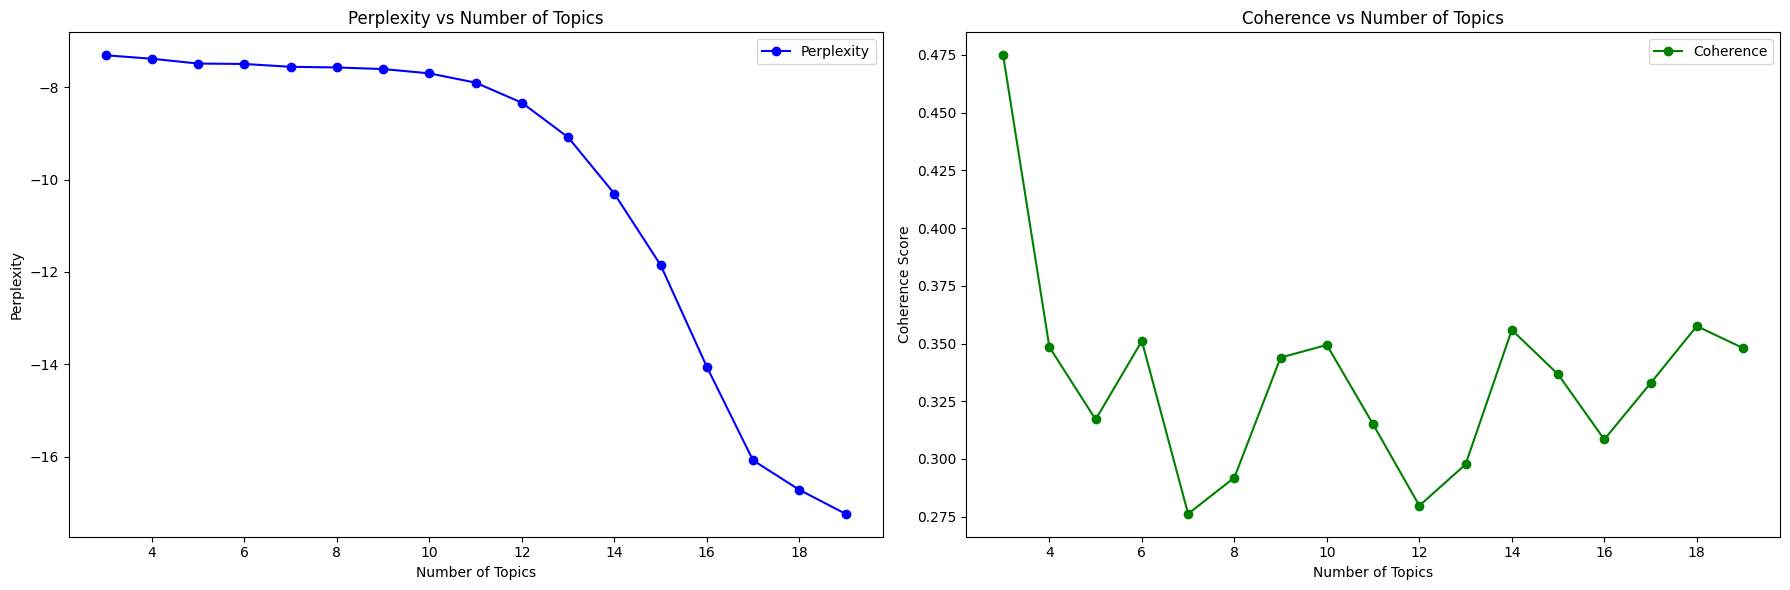

In [ ]:
# Filter the dataset for the selected class
X_target = preprocessed_train[preprocessed_train['Class Index'] == "Business"]
X_target = X_target['processed']
X_target = X_target.apply(eval).tolist()

# Create the dictionary and Bag-of-Words corpus
dictionary = gensim.corpora.Dictionary(X_target)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
bow_corpus_target = [dictionary.doc2bow(doc) for doc in X_target]

# Range of num_topics to evaluate
topic_range = range(3, 20)

# Lists to store the results
perplexity_values = []
coherence_values = []
lda_models = {}  # Store LDA models for generating Word Clouds

# Directory to save plots
output_dir = f"/content/gdrive/My Drive/Text_mining_project/Business"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop to calculate Perplexity and Coherence Score
# Select topics based on coherence values
best_topics = {}
for num_topics in topic_range:
    print(f"\n\033[1mEVALUATION FOR \033[48;5;226m\033[30m{num_topics} TOPICS\033[0m\033[1m:\033[0m")

    # Create an LDA model with the current number of topics
    lda_model = gensim.models.LdaModel(
        bow_corpus_target,         # Bag-of-Words representation of the corpus
        id2word=dictionary,        # Dictionary mapping ID to word
        num_topics=num_topics,     # Number of topics to generate
        passes=3,                  # Number of passes over the corpus
        iterations=150,            # Number of iterations per topic
        alpha= 'asymmetric',       # Sparsity in document-topic distribution (stronger topic dominance)
        eta='auto',                # Sparse topic-word distribution
        chunksize=50,              # Process 50 documents at a time
        update_every=1,            # Update the model every iteration
        per_word_topics=False      # Avoid additional calculations to speed up the model
    )

    # Store the model for WordCloud generation later
    lda_models[num_topics] = lda_model

    # Calculate Perplexity
    perplexity = lda_model.log_perplexity(bow_corpus_target)
    perplexity_values.append(perplexity)

    # Calculate Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=X_target,            # Use the filtered texts based on the target class index
        dictionary=dictionary,
        coherence='c_v'            # Can be changed to another coherence metric like 'u_mass'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

    # Get topic indices sorted by coherence for this specific model
    sorted_indices = sorted(range(num_topics), key=lambda i: coherence_model.get_coherence_per_topic()[i], reverse=True)

    if num_topics <= 10:
        best_topics[num_topics] = sorted_indices[:3]
    elif 11 <= num_topics <= 20:
        best_topics[num_topics] = sorted_indices[:2]
    elif 21 <= num_topics <= 30:
        best_topics[num_topics] = [sorted_indices[0]]

    # Print Perplexity and Coherence for each iteration
    print(f"Perplexity = {perplexity:.3f}")
    print(f"Coherence = {coherence:.3f}")


# Plotting the results
plt.figure(figsize=(18, 6))

# Perplexity plot
plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexity_values, marker='o', label='Perplexity', color='blue')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()

# Save the perplexity plot
plt.savefig(os.path.join(output_dir, "Perplexity_Plot.png"), dpi=300)

# Coherence plot
plt.subplot(1, 2, 2)
plt.plot(topic_range, coherence_values, marker='o', label='Coherence', color='green')
plt.title('Coherence vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()

# Save the coherence plot
plt.savefig(os.path.join(output_dir, "Coherence_Plot.png"), dpi=300)

plt.tight_layout()

# Save the combined figure
plt.savefig(os.path.join(output_dir, "Combined_Plot.png"), dpi=300)

# Show the plots
plt.show()

Generation and visualization of the WordClouds for multiple topics.

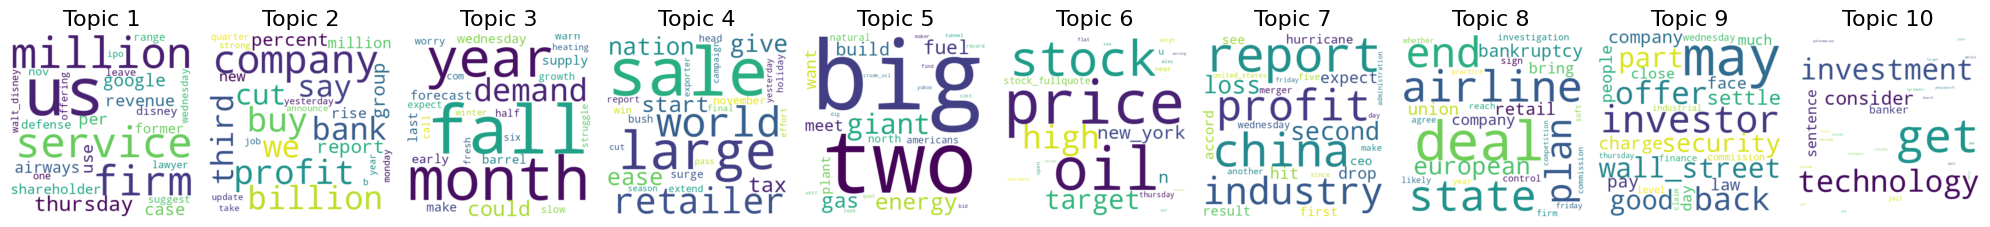

In [ ]:
def display_topic_influences(lda_model, num_topics):
    try:
        # Create a figure for all WordClouds
        fig, axes = plt.subplots(1, num_topics, figsize=(20, 8), squeeze=False)

        for topic_id in range(num_topics):
            # Get terms and their weights for the topic
            terms = lda_model.get_topic_terms(topicid=topic_id, topn=25)  # Get tuples (term_id, weight)
            word_weights = {lda_model.id2word[term_id]: weight for term_id, weight in terms}

            # Generate WordCloud using term weights
            wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_weights)

            # Plot each WordCloud
            ax = axes[0, topic_id]
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"Topic {topic_id + 1}", fontsize=16)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while generating WordClouds: {e}")

num_topics = 10

# Display WordClouds in console based on topic influences
display_topic_influences(lda_model, num_topics)

### On **Sport** news

Creation of the perplexity and the coherence plots.


EVALUATION FOR 3 TOPICS:


Perplexity = -7.645
Coherence = 0.343

EVALUATION FOR 4 TOPICS:
Perplexity = -7.771
Coherence = 0.319

EVALUATION FOR 5 TOPICS:
Perplexity = -7.824
Coherence = 0.263

EVALUATION FOR 6 TOPICS:
Perplexity = -7.851
Coherence = 0.306

EVALUATION FOR 7 TOPICS:
Perplexity = -7.920
Coherence = 0.311

EVALUATION FOR 8 TOPICS:
Perplexity = -7.951
Coherence = 0.282

EVALUATION FOR 9 TOPICS:
Perplexity = -8.019
Coherence = 0.313

EVALUATION FOR 10 TOPICS:
Perplexity = -8.086
Coherence = 0.305

EVALUATION FOR 11 TOPICS:
Perplexity = -8.284
Coherence = 0.323

EVALUATION FOR 12 TOPICS:
Perplexity = -8.893
Coherence = 0.310

EVALUATION FOR 13 TOPICS:
Perplexity = -9.761
Coherence = 0.293

EVALUATION FOR 14 TOPICS:
Perplexity = -11.215
Coherence = 0.283

EVALUATION FOR 15 TOPICS:
Perplexity = -13.349
Coherence = 0.285

EVALUATION FOR 16 TOPICS:
Perplexity = -15.568
Coherence = 0.312

EVALUATION FOR 17 TOPICS:
Perplexity = -17.123
Coherence = 0.304

EVALUATION FOR 18 TOPICS:
Perplexity = -17.933
Cohere

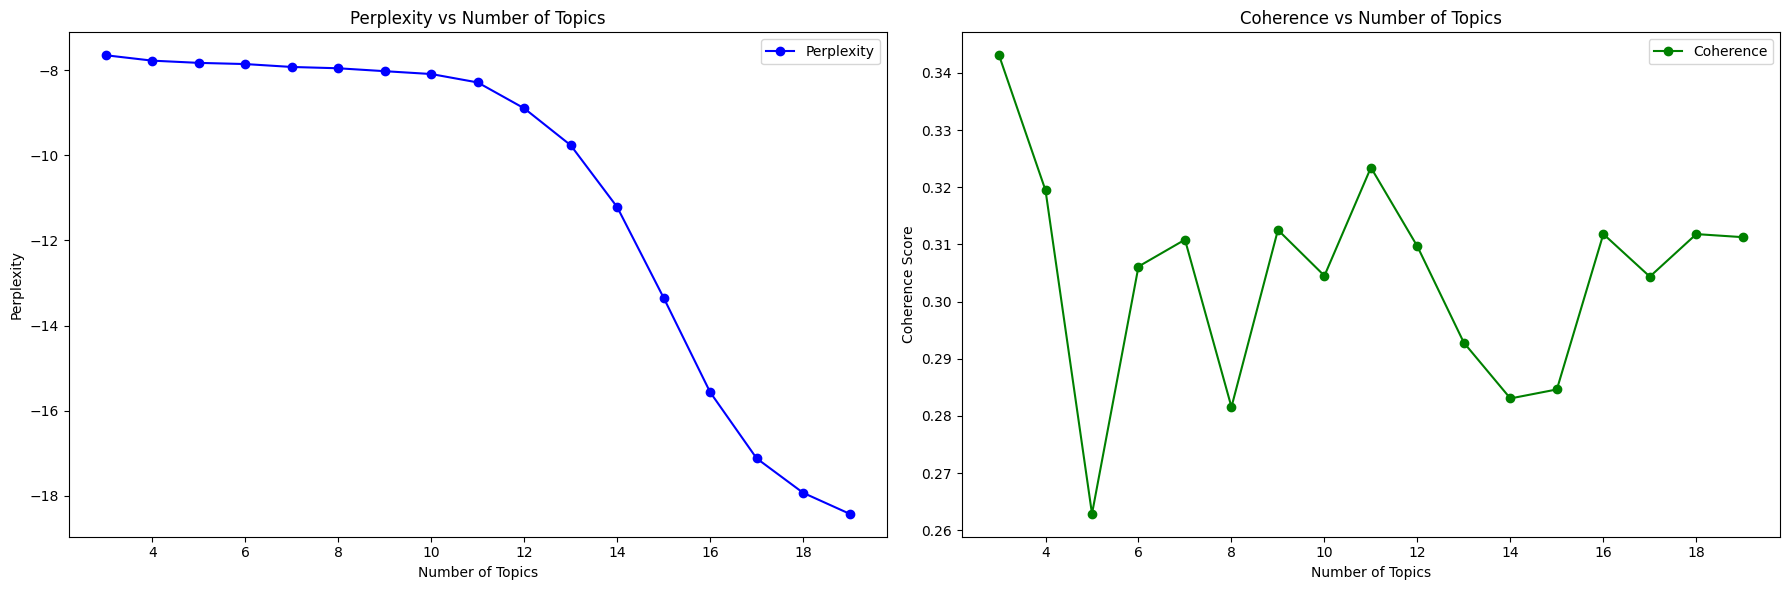

In [ ]:
# Filter the dataset for the selected class
X_target = preprocessed_train[preprocessed_train['Class Index'] == "Sport"]
X_target = X_target['processed']
X_target = X_target.apply(eval).tolist()

# Create the dictionary and Bag-of-Words corpus
dictionary = gensim.corpora.Dictionary(X_target)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
bow_corpus_target = [dictionary.doc2bow(doc) for doc in X_target]

# Range of num_topics to evaluate
topic_range = range(3, 20)

# Lists to store the results
perplexity_values = []
coherence_values = []
lda_models = {}  # Store LDA models for generating Word Clouds

# Directory to save plots
output_dir = f"/content/gdrive/My Drive/Text_mining_project/Sport"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop to calculate Perplexity and Coherence Score
# Select topics based on coherence values
best_topics = {}
for num_topics in topic_range:
    print(f"\n\033[1mEVALUATION FOR \033[48;5;226m\033[30m{num_topics} TOPICS\033[0m\033[1m:\033[0m")

    # Create an LDA model with the current number of topics
    lda_model = gensim.models.LdaModel(
        bow_corpus_target,         # Bag-of-Words representation of the corpus
        id2word=dictionary,        # Dictionary mapping ID to word
        num_topics=num_topics,     # Number of topics to generate
        passes=3,                  # Number of passes over the corpus
        iterations=150,            # Number of iterations per topic
        alpha= 'asymmetric',       # Sparsity in document-topic distribution (stronger topic dominance)
        eta='auto',                # Sparse topic-word distribution
        chunksize=50,              # Process 50 documents at a time
        update_every=1,            # Update the model every iteration
        per_word_topics=False      # Avoid additional calculations to speed up the model
    )

    # Store the model for WordCloud generation later
    lda_models[num_topics] = lda_model

    # Calculate Perplexity
    perplexity = lda_model.log_perplexity(bow_corpus_target)
    perplexity_values.append(perplexity)

    # Calculate Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=X_target,            # Use the filtered texts based on the target class index
        dictionary=dictionary,
        coherence='c_v'            # Can be changed to another coherence metric like 'u_mass'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

    # Get topic indices sorted by coherence for this specific model
    sorted_indices = sorted(range(num_topics), key=lambda i: coherence_model.get_coherence_per_topic()[i], reverse=True)

    if num_topics <= 10:
        best_topics[num_topics] = sorted_indices[:3]
    elif 11 <= num_topics <= 20:
        best_topics[num_topics] = sorted_indices[:2]
    elif 21 <= num_topics <= 30:
        best_topics[num_topics] = [sorted_indices[0]]

    # Print Perplexity and Coherence for each iteration
    print(f"Perplexity = {perplexity:.3f}")
    print(f"Coherence = {coherence:.3f}")


# Plotting the results
plt.figure(figsize=(18, 6))

# Perplexity plot
plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexity_values, marker='o', label='Perplexity', color='blue')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()

# Save the perplexity plot
plt.savefig(os.path.join(output_dir, "Perplexity_Plot.png"), dpi=300)

# Coherence plot
plt.subplot(1, 2, 2)
plt.plot(topic_range, coherence_values, marker='o', label='Coherence', color='green')
plt.title('Coherence vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()

# Save the coherence plot
plt.savefig(os.path.join(output_dir, "Coherence_Plot.png"), dpi=300)

plt.tight_layout()

# Save the combined figure
plt.savefig(os.path.join(output_dir, "Combined_Plot.png"), dpi=300)

# Show the plots
plt.show()

Generation and visualization of the WordClouds for multiple topics.

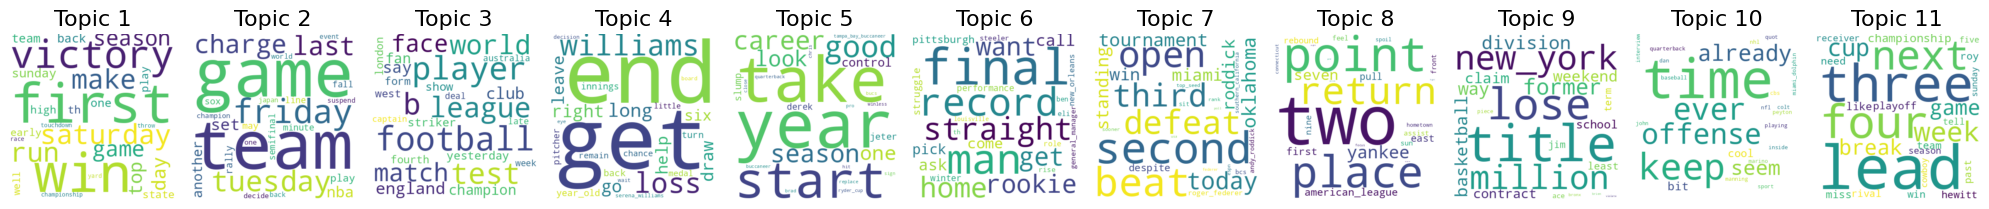

In [ ]:
def display_topic_influences(lda_model, num_topics):
    try:
        # Create a figure for all WordClouds
        fig, axes = plt.subplots(1, num_topics, figsize=(20, 8), squeeze=False)

        for topic_id in range(num_topics):
            # Get terms and their weights for the topic
            terms = lda_model.get_topic_terms(topicid=topic_id, topn=25)  # Get tuples (term_id, weight)
            word_weights = {lda_model.id2word[term_id]: weight for term_id, weight in terms}

            # Generate WordCloud using term weights
            wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_weights)

            # Plot each WordCloud
            ax = axes[0, topic_id]
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"Topic {topic_id + 1}", fontsize=16)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while generating WordClouds: {e}")

num_topics = 11

# Display WordClouds in console based on topic influences
display_topic_influences(lda_model, num_topics)

### On **Sci/Tech** news

Creation of the perplexity and the coherence plots.


EVALUATION FOR 3 TOPICS:


Perplexity = -7.584
Coherence = 0.317

EVALUATION FOR 4 TOPICS:
Perplexity = -7.674
Coherence = 0.277

EVALUATION FOR 5 TOPICS:
Perplexity = -7.767
Coherence = 0.238

EVALUATION FOR 6 TOPICS:
Perplexity = -7.796
Coherence = 0.278

EVALUATION FOR 7 TOPICS:
Perplexity = -7.799
Coherence = 0.280

EVALUATION FOR 8 TOPICS:
Perplexity = -7.851
Coherence = 0.291

EVALUATION FOR 9 TOPICS:
Perplexity = -7.939
Coherence = 0.268

EVALUATION FOR 10 TOPICS:
Perplexity = -7.980
Coherence = 0.278

EVALUATION FOR 11 TOPICS:
Perplexity = -8.233
Coherence = 0.302

EVALUATION FOR 12 TOPICS:
Perplexity = -8.720
Coherence = 0.263

EVALUATION FOR 13 TOPICS:
Perplexity = -9.640
Coherence = 0.280

EVALUATION FOR 14 TOPICS:
Perplexity = -10.933
Coherence = 0.277

EVALUATION FOR 15 TOPICS:
Perplexity = -12.899
Coherence = 0.294

EVALUATION FOR 16 TOPICS:
Perplexity = -15.100
Coherence = 0.297

EVALUATION FOR 17 TOPICS:
Perplexity = -16.924
Coherence = 0.322

EVALUATION FOR 18 TOPICS:
Perplexity = -17.619
Cohere

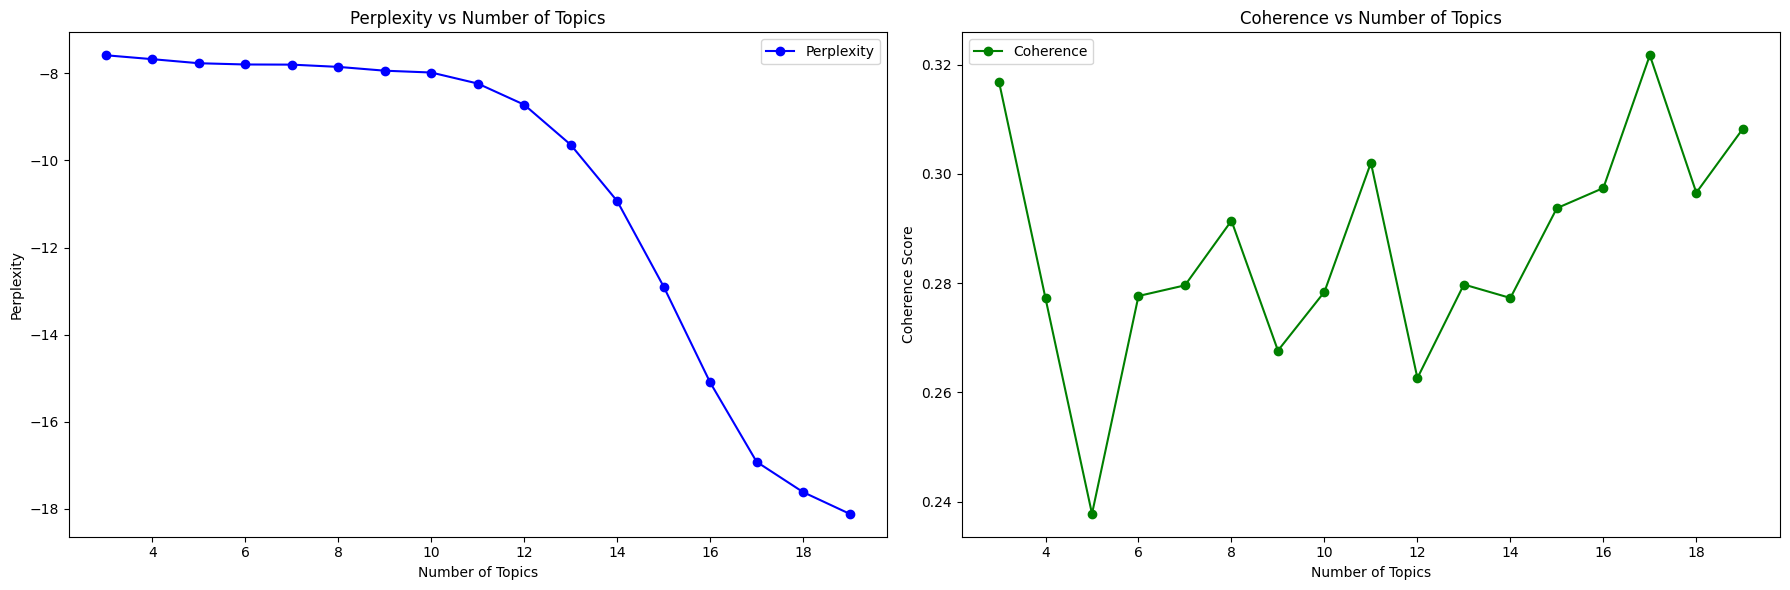

In [ ]:
# Filter the dataset for the selected class
X_target = preprocessed_train[preprocessed_train['Class Index'] == "Sci/Tech"]
X_target = X_target['processed']
X_target = X_target.apply(eval).tolist()

# Create the dictionary and Bag-of-Words corpus
dictionary = gensim.corpora.Dictionary(X_target)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
bow_corpus_target = [dictionary.doc2bow(doc) for doc in X_target]

# Range of num_topics to evaluate
topic_range = range(3, 20)

# Lists to store the results
perplexity_values = []
coherence_values = []
lda_models = {}  # Store LDA models for generating Word Clouds

# Directory to save plots
output_dir = f"/content/gdrive/My Drive/Text_mining_project/SciTech"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop to calculate Perplexity and Coherence Score
# Select topics based on coherence values
best_topics = {}
for num_topics in topic_range:
    print(f"\n\033[1mEVALUATION FOR \033[48;5;226m\033[30m{num_topics} TOPICS\033[0m\033[1m:\033[0m")

    # Create an LDA model with the current number of topics
    lda_model = gensim.models.LdaModel(
        bow_corpus_target,         # Bag-of-Words representation of the corpus
        id2word=dictionary,        # Dictionary mapping ID to word
        num_topics=num_topics,     # Number of topics to generate
        passes=3,                  # Number of passes over the corpus
        iterations=150,            # Number of iterations per topic
        alpha= 'asymmetric',       # Sparsity in document-topic distribution (stronger topic dominance)
        eta='auto',                # Sparse topic-word distribution
        chunksize=50,              # Process 50 documents at a time
        update_every=1,            # Update the model every iteration
        per_word_topics=False      # Avoid additional calculations to speed up the model
    )

    # Store the model for WordCloud generation later
    lda_models[num_topics] = lda_model

    # Calculate Perplexity
    perplexity = lda_model.log_perplexity(bow_corpus_target)
    perplexity_values.append(perplexity)

    # Calculate Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=X_target,            # Use the filtered texts based on the target class index
        dictionary=dictionary,
        coherence='c_v'            # Can be changed to another coherence metric like 'u_mass'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

    # Get topic indices sorted by coherence for this specific model
    sorted_indices = sorted(range(num_topics), key=lambda i: coherence_model.get_coherence_per_topic()[i], reverse=True)

    if num_topics <= 10:
        best_topics[num_topics] = sorted_indices[:3]
    elif 11 <= num_topics <= 20:
        best_topics[num_topics] = sorted_indices[:2]
    elif 21 <= num_topics <= 30:
        best_topics[num_topics] = [sorted_indices[0]]

    # Print Perplexity and Coherence for each iteration
    print(f"Perplexity = {perplexity:.3f}")
    print(f"Coherence = {coherence:.3f}")


# Plotting the results
plt.figure(figsize=(18, 6))

# Perplexity plot
plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexity_values, marker='o', label='Perplexity', color='blue')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()

# Save the perplexity plot
plt.savefig(os.path.join(output_dir, "Perplexity_Plot.png"), dpi=300)

# Coherence plot
plt.subplot(1, 2, 2)
plt.plot(topic_range, coherence_values, marker='o', label='Coherence', color='green')
plt.title('Coherence vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()

# Save the coherence plot
plt.savefig(os.path.join(output_dir, "Coherence_Plot.png"), dpi=300)

plt.tight_layout()

# Save the combined figure
plt.savefig(os.path.join(output_dir, "Combined_Plot.png"), dpi=300)

# Show the plots
plt.show()

Generation and visualization of the WordClouds for multiple topics.

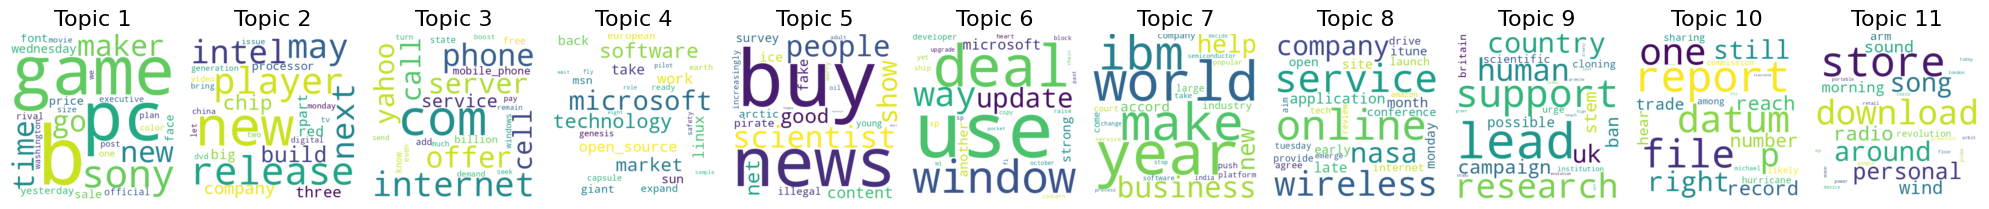

In [ ]:
def display_topic_influences(lda_model, num_topics):
    try:
        # Create a figure for all WordClouds
        fig, axes = plt.subplots(1, num_topics, figsize=(20, 8), squeeze=False)

        for topic_id in range(num_topics):
            # Get terms and their weights for the topic
            terms = lda_model.get_topic_terms(topicid=topic_id, topn=25)  # Get tuples (term_id, weight)
            word_weights = {lda_model.id2word[term_id]: weight for term_id, weight in terms}

            # Generate WordCloud using term weights
            wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_weights)

            # Plot each WordCloud
            ax = axes[0, topic_id]
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"Topic {topic_id + 1}", fontsize=16)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while generating WordClouds: {e}")

num_topics = 11

# Display WordClouds in console based on topic influences
display_topic_influences(lda_model, num_topics)

### On **World** news

Creation of the perplexity and the coherence plots.


EVALUATION FOR 3 TOPICS:


Perplexity = -7.504
Coherence = 0.432

EVALUATION FOR 4 TOPICS:
Perplexity = -7.595
Coherence = 0.338

EVALUATION FOR 5 TOPICS:
Perplexity = -7.705
Coherence = 0.273

EVALUATION FOR 6 TOPICS:
Perplexity = -7.738
Coherence = 0.288

EVALUATION FOR 7 TOPICS:
Perplexity = -7.758
Coherence = 0.289

EVALUATION FOR 8 TOPICS:
Perplexity = -7.795
Coherence = 0.313

EVALUATION FOR 9 TOPICS:
Perplexity = -7.836
Coherence = 0.309

EVALUATION FOR 10 TOPICS:
Perplexity = -7.927
Coherence = 0.308

EVALUATION FOR 11 TOPICS:
Perplexity = -8.171
Coherence = 0.281

EVALUATION FOR 12 TOPICS:
Perplexity = -8.623
Coherence = 0.318

EVALUATION FOR 13 TOPICS:
Perplexity = -9.444
Coherence = 0.332

EVALUATION FOR 14 TOPICS:
Perplexity = -10.669
Coherence = 0.343

EVALUATION FOR 15 TOPICS:
Perplexity = -12.556
Coherence = 0.310

EVALUATION FOR 16 TOPICS:
Perplexity = -14.887
Coherence = 0.368

EVALUATION FOR 17 TOPICS:
Perplexity = -16.787
Coherence = 0.354

EVALUATION FOR 18 TOPICS:
Perplexity = -17.743
Cohere

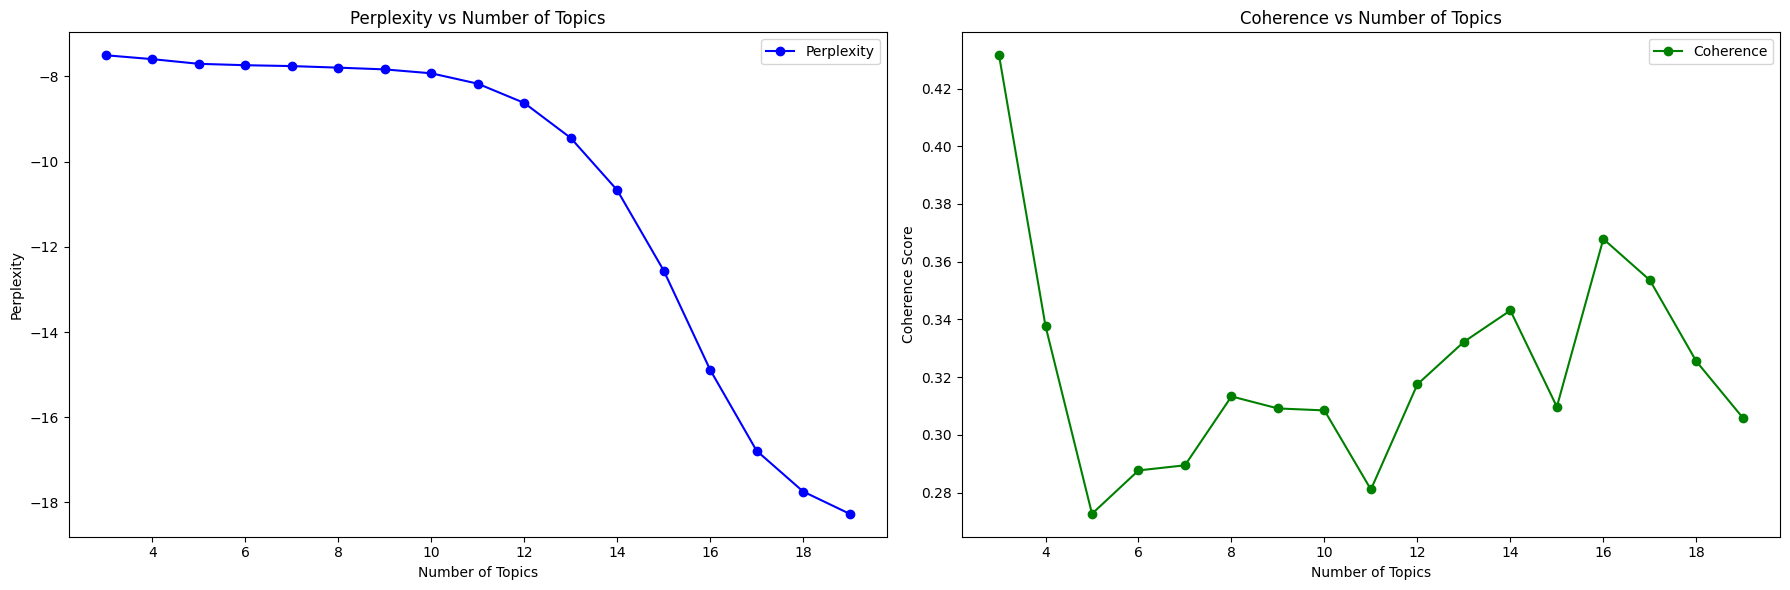

In [ ]:
# Filter the dataset for the selected class
X_target = preprocessed_train[preprocessed_train['Class Index'] == "World"]
X_target = X_target['processed']
X_target = X_target.apply(eval).tolist()

# Create the dictionary and Bag-of-Words corpus
dictionary = gensim.corpora.Dictionary(X_target)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
bow_corpus_target = [dictionary.doc2bow(doc) for doc in X_target]

# Range of num_topics to evaluate
topic_range = range(3, 20)

# Lists to store the results
perplexity_values = []
coherence_values = []
lda_models = {}  # Store LDA models for generating Word Clouds

# Directory to save plots
output_dir = f"/content/gdrive/My Drive/Text_mining_project/World"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop to calculate Perplexity and Coherence Score
# Select topics based on coherence values
best_topics = {}
for num_topics in topic_range:
    print(f"\n\033[1mEVALUATION FOR \033[48;5;226m\033[30m{num_topics} TOPICS\033[0m\033[1m:\033[0m")

    # Create an LDA model with the current number of topics
    lda_model = gensim.models.LdaModel(
        bow_corpus_target,         # Bag-of-Words representation of the corpus
        id2word=dictionary,        # Dictionary mapping ID to word
        num_topics=num_topics,     # Number of topics to generate
        passes=3,                  # Number of passes over the corpus
        iterations=150,            # Number of iterations per topic
        alpha= 'asymmetric',       # Sparsity in document-topic distribution (stronger topic dominance)
        eta='auto',                # Sparse topic-word distribution
        chunksize=50,              # Process 50 documents at a time
        update_every=1,            # Update the model every iteration
        per_word_topics=False      # Avoid additional calculations to speed up the model
    )

    # Store the model for WordCloud generation later
    lda_models[num_topics] = lda_model

    # Calculate Perplexity
    perplexity = lda_model.log_perplexity(bow_corpus_target)
    perplexity_values.append(perplexity)

    # Calculate Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=X_target,            # Use the filtered texts based on the target class index
        dictionary=dictionary,
        coherence='c_v'            # Can be changed to another coherence metric like 'u_mass'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)

    # Get topic indices sorted by coherence for this specific model
    sorted_indices = sorted(range(num_topics), key=lambda i: coherence_model.get_coherence_per_topic()[i], reverse=True)

    if num_topics <= 10:
        best_topics[num_topics] = sorted_indices[:3]
    elif 11 <= num_topics <= 20:
        best_topics[num_topics] = sorted_indices[:2]
    elif 21 <= num_topics <= 30:
        best_topics[num_topics] = [sorted_indices[0]]

    # Print Perplexity and Coherence for each iteration
    print(f"Perplexity = {perplexity:.3f}")
    print(f"Coherence = {coherence:.3f}")


# Plotting the results
plt.figure(figsize=(18, 6))

# Perplexity plot
plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexity_values, marker='o', label='Perplexity', color='blue')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()

# Save the perplexity plot
plt.savefig(os.path.join(output_dir, "Perplexity_Plot.png"), dpi=300)

# Coherence plot
plt.subplot(1, 2, 2)
plt.plot(topic_range, coherence_values, marker='o', label='Coherence', color='green')
plt.title('Coherence vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()

# Save the coherence plot
plt.savefig(os.path.join(output_dir, "Coherence_Plot.png"), dpi=300)

plt.tight_layout()

# Save the combined figure
plt.savefig(os.path.join(output_dir, "Combined_Plot.png"), dpi=300)

# Show the plots
plt.show()

Generation and visualization of the WordClouds for multiple topics.

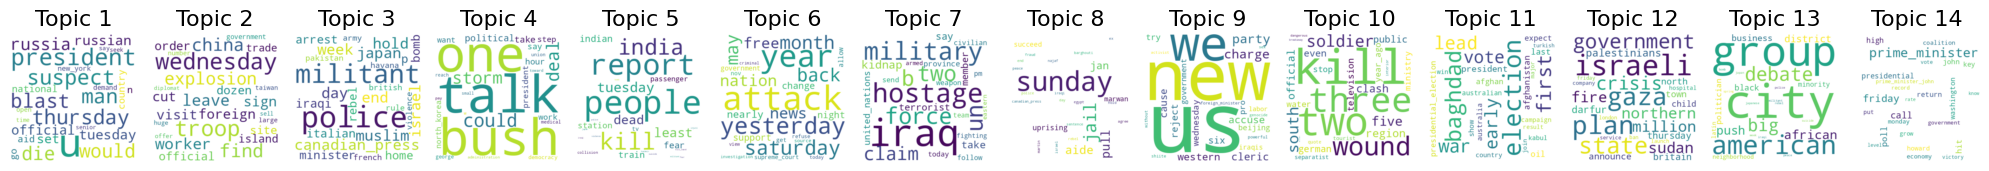

In [ ]:
def display_topic_influences(lda_model, num_topics):
    try:
        # Create a figure for all WordClouds
        fig, axes = plt.subplots(1, num_topics, figsize=(20, 8), squeeze=False)

        for topic_id in range(num_topics):
            # Get terms and their weights for the topic
            terms = lda_model.get_topic_terms(topicid=topic_id, topn=25)  # Get tuples (term_id, weight)
            word_weights = {lda_model.id2word[term_id]: weight for term_id, weight in terms}

            # Generate WordCloud using term weights
            wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_weights)

            # Plot each WordCloud
            ax = axes[0, topic_id]
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"Topic {topic_id + 1}", fontsize=16)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while generating WordClouds: {e}")

num_topics = 14

# Display WordClouds in console based on topic influences
display_topic_influences(lda_model, num_topics)